## MasterProject SoSe22: "Non-Intrusive Load Monitoring" (NILM)

### Related Work and Backgrounds

- Use publicly available data sets **RAE**, as described by [Makonin et al., 2019] in their paper "RAE: The Rainforest Automation Energy Dataset for Smart Grid Meter Data Analysis".
- Follow general NILM problem description, outlined by [Marwah and Han, 2011] in their paper "Unsupervised Disaggregation of Low Frequency Power Measurements".
- A nice overview of various state-of-the-art techniques used for NILM is found in [Herrero et al., 2018] paper "Non Intrusive Load Monitoring (NILM):A State of the Art", including LSTM models.
- [Herrero et al., 2018] references a PhD Thesis [Kelly, 2017] on "Disaggregation of domestic smart meter energy data": Find in Section 9.4.3 a detailed description of a CNN model.

### Game Plan

#### Data

Decided to work on **RAE data set**. That provides total power consumption and submeter data for two houses. Pick the **first house** in this work and find **24 submeters** and **two sampling periods** of 9 and 63 days, respectively. **Sampling rate is 1Hz**. 

**Idea:** Could use 63 days sample for training before testing the model on the second sample covering 9 days.

#### Problem Statement

Given an aggregate power consumption $Y$ for a total of $T$ time periods:

$$Y = (y_1, y_2,..,y_T)$$

We then want to infer the power load of each of the $M$ appliances for all time steps:

$$ Q^{(1)} = (q^{(1)}_1, q^{(1)}_2,..,q^{(1)}_T) \\
   Q^{(2)} = (q^{(2)}_1, q^{(2)}_2,..,q^{(2)}_T) \\
   ... \\
   Q^{(M)} = (q^{(M)}_1, q^{(M)}_2,..,q^{(M)}_T)
$$

#### Model

There exist various approaches for dissagregation of total power consumption. Here we focus on **deep ANN models** from the domain of **supervised machine learning** techniques. The idea is as follows:

- Feed a sample consisting of a number of time steps of the total power consumption time series as input.
- We use a **sliding window approach** and the appropriate **input length** needs to be specified.
- Later we could extend the model and feed time of the day and/or day of the week as **additional input features**.
- As **target** we have **three scalar values** for each of the $M$ submeters. **Note:** We might not use all submeters or further aggregate certain submeters!
- These three scalar values are **start time, end time and average power consumption for a given submeter** (or aggregate submeters). **Note:** We only predict the *first* usage in the given sample. Details on scaling these three features can be found in Section 9.4.3 of [Kelly, 2017].
- Most promising appears a **CNN/fc model** consisting of one or more CNN layers followd by one or more fully connected (fc) layers with 3 output units. Further details on model setup can also be found in Section 9.4.3 of [Kelly, 2017].
- We then have one (sub-)model for each submeter. Could also try to predict 3 output values for *all* $M$ submeters simultaneously - using $3 \times M$ output units.

#### Data Inspection and Pre-Processing

- **Download data** of both sampling periods for house1 from cloud storage.

For our example house we know not only the aggregate power consumption $Y$ but also power load of each of the $M$ appliances $Q^{(1)},Q^{(2)},..,Q^{(M)}$.

- Create **histogram of appliances' power consumption and ON-durations** as in Figures 2 and 3 of [Marwah and Han, 2011]. 

Expect to find some narrow Gaussian distribution for appliances' power consumption. We could then use mean power consumption for each appliance as a given "steady state feature" and only model ON-durations. However, we will try to predict average power consumption as well, as explained above.

The histogram of ON-durations gives us a feeling for an appropriate input length in our sliding window approach, also explained above.

- Add "time of day" and "day of week" as "non traditional features" from given unix timestamp (= sec passed since Jan 1st, 1970, 00:00h UTC).

Most important pre-processing step is **labelling the submeter time series**:

- Split power load of each of the $M$ appliances into sequences of specified input length.
- Get start time, end time and average power consumption for a given submeter in every sample, scale to [0,1]. **Note:** Only encounter *first* usage in sample, ignore further usages! If submeter is *not* used in sample, all three values are *zero*.

### Tech Preamble

In [1]:
import numpy as np
from os.path import join
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, MaxPooling1D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

### Load and inspect Data

In [2]:
## Read input files:

# Have TWO continuous samples covering 9 (data1) and 63 days (data2), respectively.

# Skip header and keep ALL columns: Unix timestamp, some interval total values,
# total power consumption ('main') followed by 24 submeters ('sub1' .. 'sub24').

# Define path to data folder:
path_to_data = "../data"

# Import data from csv files:
data1 = np.genfromtxt(join(path_to_data,'house1_power_blk1.csv'), delimiter=',', skip_header=1)
data2 = np.genfromtxt(join(path_to_data,'house1_power_blk2.csv'), delimiter=',', skip_header=1)
#data2 = data1 # to save time, when only working with data1

In [3]:
# Check dimensions:
print("data1 shape (samples, features): ", data1.shape)
print("data2 shape (samples, features): ", data2.shape)
print("\ndata1 contains ", np.round(data1.shape[0]/ (24*3600),2), " days")
print("data2 contains ", np.round(data2.shape[0]/ (24*3600),2), " days")

data1 shape (samples, features):  (777600, 27)
data2 shape (samples, features):  (5439600, 27)

data1 contains  9.0  days
data2 contains  62.96  days


In [4]:
# Check for NaN values in data (main and submeters, only):
print("NaN values in data1: ",np.sum(np.isnan(data1[:,2:])))
print("NaN values in data2: ",np.sum(np.isnan(data2[:,2:])))
print("\nNaN values for main and submeters in data2: \n", np.sum(np.isnan(data2[:,2:]), axis=0)) # 21 sec missing data

NaN values in data1:  0
NaN values in data2:  525

NaN values for main and submeters in data2: 
 [21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21 21
 21]


In [5]:
# Replace NaN values in data2 by zero:
(data2[:,2:])[np.isnan(data2[:,2:])]=0

In [16]:
# Want to train models for appliances with relatively long ON phases: DishWasher, ClothesDryer, ClothesWasher.
# These appliances have only few events. Decide to train models on data2 (covering 63 days).
# Then use data1 (covering 9 days) for validation.
# But need to downsample data to handle the amount of data.
# Switch to 5 Hz by only considering every 5th sample.

data1_small = data1[np.arange(0, len(data1), 5)]
data2_small = data2[np.arange(0, len(data2), 5)]
print("data1 shape after downsampling: ", data1_small.shape)
print("data2 shape after downsampling: ", data2_small.shape)

data1 shape after downsampling:  (155520, 27)
data2 shape after downsampling:  (1087920, 27)


In [17]:
## Create labels for 24 submeters in house 1 (copy from house1_labels.txt)

# Numbers of submeters:
labels_num = np.arange(1,25,1)

# Text labels:
labels_long = ['Kitchen Wall Oven L1','Kitchen Wall Oven L2','Kitchen Counter Plugs L1','Kitchen Counter Plugs L2',
               'Clothes Dryer L1','Clothes Dryer L2','Upstairs Bedroom AFCI Arc-Fault Plugs','Kitchen Fridge',
               'Clothes Washer','Kitchen Dishwasher','Furnace & Hot Water Unit (incl. Furnace Room Plug)',
               'Basement Plugs & Lights (incl. Outside Plugs)','Heat Pump L1','Heat Pump L2','Garage Sub-Panel L1',
               'Garage Sub-Panel L2','Upstairs Plugs & Lights L1 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Upstairs Plugs & Lights L2 (incl. Bathroom Lights and Vent Fan, Smoke Alarms, Living Room Plugs)',
               'Basement Blue Plugs (incl. Ent. TV/Amp/DVD/PVR)','Bathrooms (incl. 3 GFCI Plugs, 2 Lights, 1 Vent Fan, Chest Freezer)',
               'Rental Suite Sub-Panel L1','Rental Suite Sub-Panel L2','Misc. Plugs (incl. Dining Room, Gas Cooktop, Microwave)',
               'Home Office (incl. Telco/Cable/Net/Security Equip.)']

In [19]:
## Try to reproduce plot of all loads for one day for house 1, as in [Makonin et al., 2019]:
## Note: stackplot needs transposed data!

# Transpose submeter data, need to skip first three columns (Unix timestamp, some interval total values,
# total power consumption ('main')):
data1_transp = np.transpose(data1_small[:,3:])
data2_transp = np.transpose(data2_small[:,3:])

In [20]:
## Further aggregate submeters to end up with 10 classes:

# Initialize storage for aggregate transposed submeter data:
data1_transp_agg = np.zeros((10,len(data1_small)))
data2_transp_agg = np.zeros((10,len(data2_small)))

## Manually aggragate submeters, as in [Makonin et al. 2019]:

# Garage: Submeters 15, 16
data1_transp_agg[0] = data1_transp[14] + data1_transp[15]
data2_transp_agg[0] = data2_transp[14] + data2_transp[15]

# Clothes Dryer: Submeters 5, 6
data1_transp_agg[1] = data1_transp[4] + data1_transp[5]
data2_transp_agg[1] = data2_transp[4] + data2_transp[5]

# HVAC & Heat Pump: Submeters 11, 13, 14
data1_transp_agg[2] = data1_transp[10] + data1_transp[12] + data1_transp[13]
data2_transp_agg[2] = data2_transp[10] + data2_transp[12] + data2_transp[13]

# Rental Suite: Submeters 21, 22
data1_transp_agg[3] = data1_transp[20] + data1_transp[21]
data2_transp_agg[3] = data2_transp[20] + data2_transp[21]

# Plugs & Lights: Submeters 3, 4, 7, 12, 17, 18, 19, 20, 23
data1_transp_agg[4] = data1_transp[2] + data1_transp[3] + data1_transp[6] + data1_transp[11] + data1_transp[16] + data1_transp[17] + data1_transp[18] + data1_transp[19] + data1_transp[22]
data2_transp_agg[4] = data2_transp[2] + data2_transp[3] + data2_transp[6] + data2_transp[11] + data2_transp[16] + data2_transp[17] + data2_transp[18] + data2_transp[19] + data2_transp[22]

# Wall Oven: Submeters 1, 2
data1_transp_agg[5] = data1_transp[0] + data1_transp[1]
data2_transp_agg[5] = data2_transp[0] + data2_transp[1]

# Fridge: Submeter 8
data1_transp_agg[6] = data1_transp[7]
data2_transp_agg[6] = data2_transp[7]

# Clothes Washer: Submeter 9
data1_transp_agg[7] = data1_transp[8]
data2_transp_agg[7] = data2_transp[8]

# Dish Washer: Submeter 10
data1_transp_agg[8] = data1_transp[9]
data2_transp_agg[8] = data2_transp[9]

# Home Office: Submeter 24
data1_transp_agg[9] = data1_transp[23]
data2_transp_agg[9] = data2_transp[23]

## Create labels for aggregate submeters:
labels_long_agg = ['Garage','Clothes Dryer','HVAC & Heat Pump','Rental Suite','Plugs & Lights','Wall Oven',
                   'Fridge','Clothes Washer','Dish Washer','Home Office']

In [21]:
# Plausibility Check: Sum of aggregated submeters must equal total energy consumption in raw data. 
# Expect zero difference!
print("plausi check sample 1 (expect 0.0): ", np.sum(np.sum(data1_transp_agg,axis=0)-data1_small[:,2]))
print("plausi check sample 2 (expect 0.0): ", np.sum(np.sum(data2_transp_agg,axis=0)-data2_small[:,2]))

plausi check sample 1 (expect 0.0):  0.0
plausi check sample 2 (expect 0.0):  0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

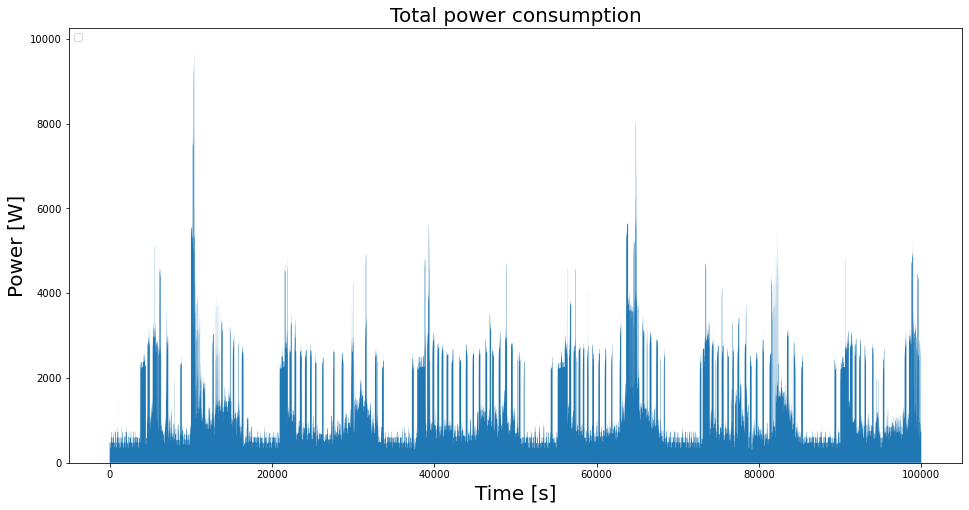

In [24]:
# Plot total power consumption from aggregate submeter data for first steps of 2nd sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(100000), np.sum(data2_transp_agg,axis=0)[:100000])
plt.legend(loc='upper left')
plt.title('Total power consumption', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

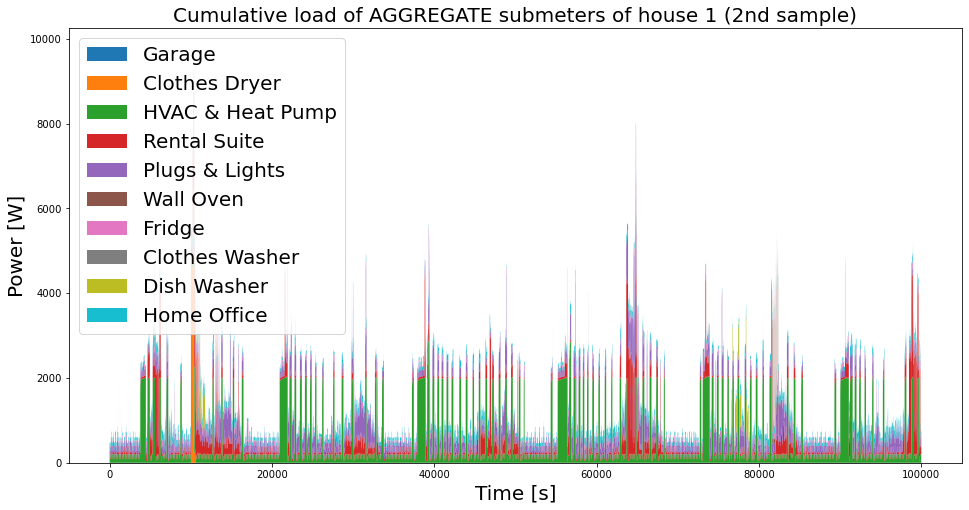

In [28]:
# Plot aggregate submeter data for first steps of 2nd sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(100000), data2_transp_agg[:,:100000], labels=labels_long_agg)
plt.legend(loc='upper left', fontsize=20)
plt.title('Cumulative load of AGGREGATE submeters of house 1 (2nd sample)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

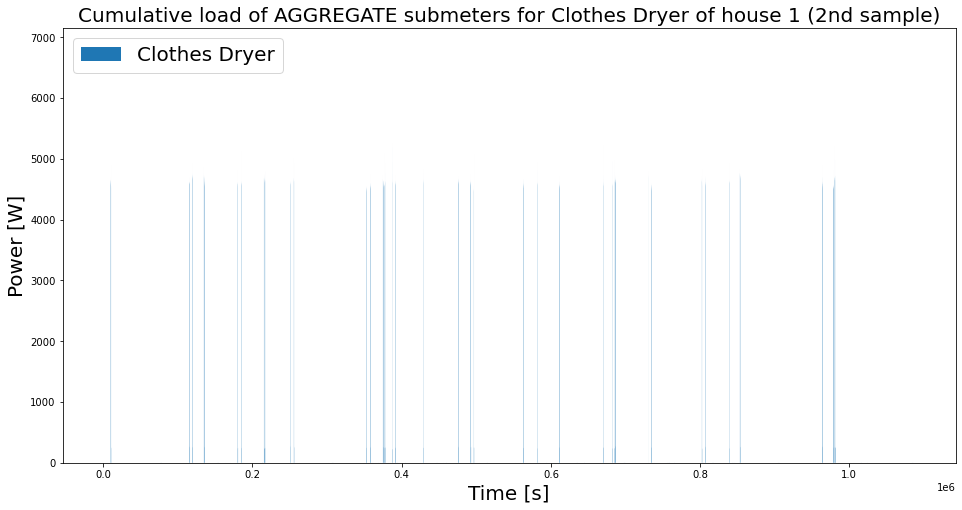

In [39]:
# Plot aggregate submeter data for Clothes Dryer in 2nd sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(data2_small)), data2_transp_agg[1:2,:], labels=(['Clothes Dryer']))
plt.legend(loc='upper left', fontsize=20)
plt.title('Cumulative load of AGGREGATE submeters for Clothes Dryer of house 1 (2nd sample)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [15]:
### NEXT: Repeat steps from Prototype (Heat Pumps) now for Clothes Dryer on downsampled data.

# Define noise level and delay time. 
# Get labels
# [Plot histogram of avg use during ON periods]
# [Plot histogram of ON durations]
# Derive reasonable input length T
# Split data
# Scale Start Time, End Time, Avg Power Load to [0,1]
# CNN / fc model
# Post-processing: Restore time series with predicted power load from predicted start/end times
# Performance Measures

In [40]:
## Extract input series for samples 1 and 2 from downsampled data: Total Power Load.
## Remember: Total Power Load is third column in data!
inputs1 = data1_small[:,2]
inputs2 = data2_small[:,2]

In [41]:
## Extract target series for samples 1 and 2 from downsampled data: Clothes Dryer (subm 5+6).
## Remember: Submeters 5+6 are columns 8 and 9 in data
target1 = np.sum(data1_small[:,7:9], axis=1)
target2 = np.sum(data2_small[:,7:9], axis=1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

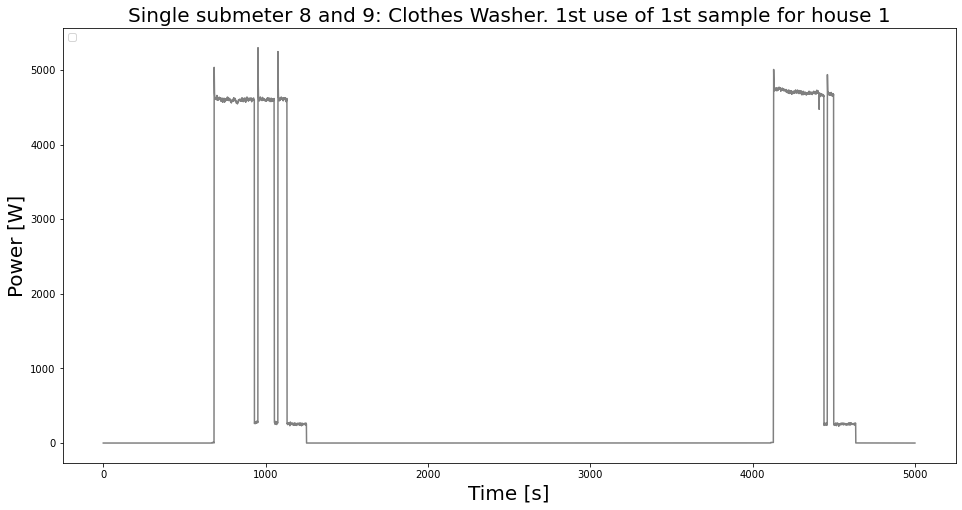

In [49]:
## Try to define noise level by visual inspection first:

# Plot Clothes Dryer load from submeter data 8 and 9 for first 2 uses in 2nd sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(target2[115000:120000], color="grey")
plt.legend(loc='upper left')
plt.title('Single submeter 8 and 9: Clothes Washer. 1st use of 1st sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)



In [50]:
## Looks like there is only very low "stand-by" power load during OFF times: Set noise level to 20 Watt.
target2[115500:116500]

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

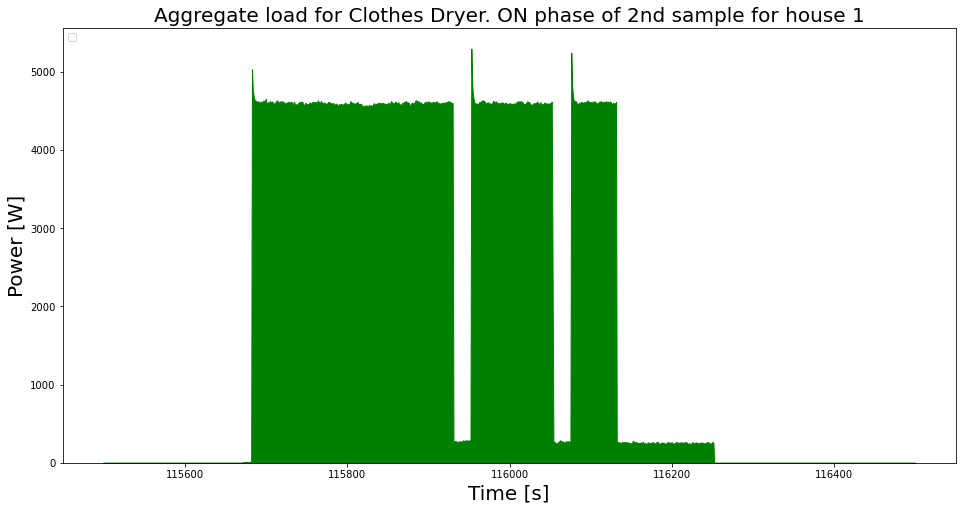

In [53]:
## Zoom into an ON phase, to see if power load unexpectedly drops to zero during ON phase:

# Plot Clothes Dryer from for example use in 2nd sample:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(115500, 116500,1), target2[115500:116500], color="green")
plt.legend(loc='upper left')
plt.title('Aggregate load for Clothes Dryer. ON phase of 2nd sample for house 1', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [54]:
## Set noise level and delay time.
## "Delay time" means, that power load is allowed to drop below noise level during ON phase for a specified
## number of seconds. If drop exceeds delay time, we assume the appliance to be switched OFF again.

# Noise level of 300 Watt seems to be appropriate, only want to capture "real" on phase, not stand-by times.
noise_level = 300

# There seem to be no unexpected drops in power load during ON phase. 
delay_time = 0

In [55]:
# Now create new binary series containing 1 (= ON) and 0 (= OFF), respecting specified noise level:
target1_ON_OFF = (target1 > noise_level).astype(int)
target2_ON_OFF = (target2 > noise_level).astype(int)

# Get power load during ON times:
target1_load = target1 * target1_ON_OFF
target2_load = target2 * target2_ON_OFF

# Get mean power load from load during ON times as single value.
# Only define mean_load from 2nd sample, since we want to use 2nd sample for training our models.
# Assume to have the same mean_load for 1st sample, used for validation.
target2_mean_load = np.mean(target2_load[target2_load>0])

# Get mean load during ON times as time series:
target1_mean_load_series = target2_mean_load * target1_ON_OFF
target2_mean_load_series = target2_mean_load * target2_ON_OFF

# Check avg usage time and mean load during ON times:
print("avg usage in 1st sample: ", np.round(np.sum(target1_ON_OFF) / len(target1) * 100, 2), "%")
print("avg usage in 2nd sample: ", np.round(np.sum(target2_ON_OFF) / len(target2) * 100, 2), "%")
print("mean load during ON times: ", np.round(target2_mean_load,2), "W")

avg usage in 1st sample:  0.96 %
avg usage in 2nd sample:  1.06 %
mean load during ON times:  4607.95 W


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Power [W]')

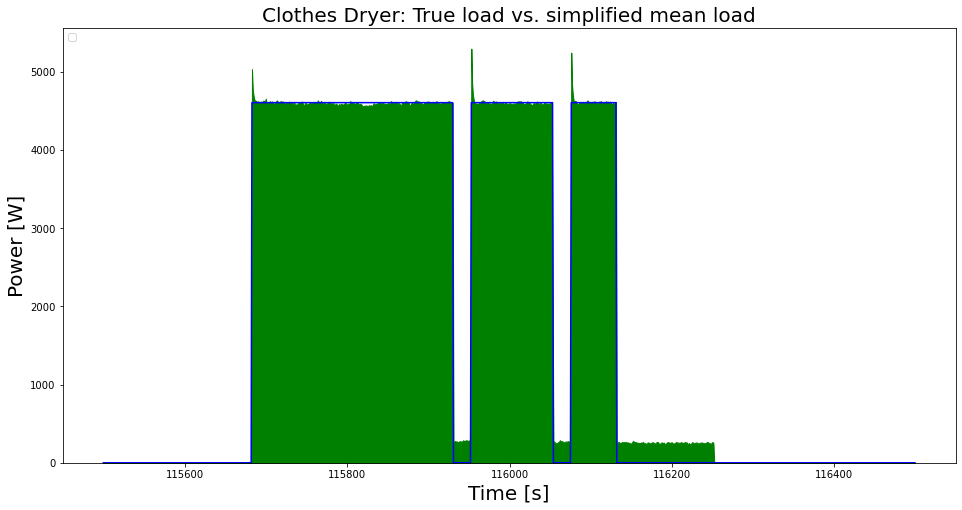

In [56]:
# Plot true load for Clothes Dryer vs. simplified mean load for
# an ON phases from 2nd sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(np.arange(115500,116500,1), target2[115500:116500], color="green")
ax.plot(np.arange(115500,116500,1), target2_mean_load_series[115500:116500], color="blue")
plt.legend(loc='upper left')
plt.title('Clothes Dryer: True load vs. simplified mean load', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

In [58]:
## Prepare labelling:

## Get switching events from binary ON_OFF series:
## Shift series by one time step and subtract original series.
## This gives us +1 for switchen ON and -1 for switching OFF.
target1_switch_events = target1_ON_OFF[1:] - target1_ON_OFF[:-1]
target2_switch_events = target2_ON_OFF[1:] - target2_ON_OFF[:-1]

## But this requires adding a ZERO as first element, to keep dimensions correct:
target1_switch_events = np.insert(target1_switch_events,0,np.array([0]))
target2_switch_events = np.insert(target2_switch_events,0,np.array([0]))

## Now get separate series for start and end times from switching event series:
target1_start_time = (target1_switch_events==1).astype(int)
target1_end_time = (target1_switch_events==-1).astype(int)
target2_start_time = (target2_switch_events==1).astype(int)
target2_end_time = (target2_switch_events==-1).astype(int)

## Check dimensions and number of switching events:
print("1st sample:")
print("\ninputs1 shape (time steps, features): ", inputs1.shape)
print("switch events series shape (time steps): ", np.shape(target1_switch_events))
print("start_time series shape (time steps): ", np.shape(target1_start_time))
print("end_time series shape (time steps): ", np.shape(target1_end_time))
print("number of ON switch events: ", np.sum(target1_switch_events==1))
print("number of OFF switch events: ", np.sum(target1_switch_events==-1))

print("\n\n2nd sample:")
print("\ninputs2 shape (time steps, features): ", inputs2.shape)
print("switch events series shape (time steps): ", np.shape(target2_switch_events))
print("start_time series shape (time steps): ", np.shape(target2_start_time))
print("end_time series shape (time steps): ", np.shape(target2_end_time))
print("number of ON switch events: ", np.sum(target2_switch_events==1))
print("number of OFF switch events: ", np.sum(target2_switch_events==-1))


1st sample:

inputs1 shape (time steps, features):  (155520,)
switch events series shape (time steps):  (155520,)
start_time series shape (time steps):  (155520,)
end_time series shape (time steps):  (155520,)
number of ON switch events:  7
number of OFF switch events:  7


2nd sample:

inputs2 shape (time steps, features):  (1087920,)
switch events series shape (time steps):  (1087920,)
start_time series shape (time steps):  (1087920,)
end_time series shape (time steps):  (1087920,)
number of ON switch events:  124
number of OFF switch events:  124


In [61]:
# Get mean ON duration:
target2_ON_time = sum(target2_ON_OFF>0)
print("mean ON duration in 2nd sample: ", np.round(target2_ON_time / np.sum(target2_switch_events==1) * 5,0), "sec")
print("since we downsampled data, this means: ", np.round(target2_ON_time / np.sum(target2_switch_events==1)), "time steps")

mean ON duration in 2nd sample:  465.0 sec
since we downsampled data, this means:  93.0 time steps


In [62]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [65]:
# Specify input length: Take a bit more than half of the mean ON duration
input_length = 50

# Split inputs and targets into sequences of specified length:
inputs1_split = split_sequence(inputs1, input_length)
target1_start_time_split = split_sequence(target1_start_time, input_length)
target1_end_time_split = split_sequence(target1_end_time, input_length)
inputs2_split = split_sequence(inputs2, input_length)
target2_start_time_split = split_sequence(target2_start_time, input_length)
target2_end_time_split = split_sequence(target2_end_time, input_length)

# Check dimensions:
print("inputs1_split shape (samples, time steps, in features): ", np.shape(inputs1_split))
print("target1_start_time_split shape (samples, time steps, out features): ", np.shape(target1_start_time_split))
print("target1_end_time_split shape (samples, time steps, out features): ", np.shape(target1_end_time_split))
print("\ninputs2_split shape (samples, time steps, in features): ", np.shape(inputs2_split))
print("target2_start_time_split shape (samples, time steps, out features): ", np.shape(target2_start_time_split))
print("target2_end_time_split shape (samples, time steps, out features): ", np.shape(target2_end_time_split))

inputs1_split shape (samples, time steps, in features):  (155471, 50)
target1_start_time_split shape (samples, time steps, out features):  (155471, 50)
target1_end_time_split shape (samples, time steps, out features):  (155471, 50)

inputs2_split shape (samples, time steps, in features):  (1087871, 50)
target2_start_time_split shape (samples, time steps, out features):  (1087871, 50)
target2_end_time_split shape (samples, time steps, out features):  (1087871, 50)


In [66]:
# Now have target samples as sequences, for both start time and end time.
# Need to convert to single target values, which shall be the position of the FIRST switching event (ON or OFF)
# relative to sequence length, hence a value in [0,1], where 0.5 refers to an event in the middle of input_length.
# If NO event is present in a sample, target value shall be ZERO.

# Initialize storage for target values: Position of start and end time
target1_start_time_pos = np.zeros((len(target1_start_time_split), 1))
target1_end_time_pos = np.zeros((len(target1_end_time_split), 1))

# Loop over target samples: Start time
for i in range(len(target1_start_time_split)):
    
    # Get current sample:
    sample = target1_start_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_start_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        
# Loop over target samples: End time
for i in range(len(target1_end_time_split)):
    
    # Get current sample:
    sample = target1_end_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target1_end_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length

        
# Initialize storage for target values: Position of start and end time
target2_start_time_pos = np.zeros((len(target2_start_time_split), 1))
target2_end_time_pos = np.zeros((len(target2_end_time_split), 1))

# Loop over target samples: Start time
for i in range(len(target2_start_time_split)):
    
    # Get current sample:
    sample = target2_start_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target2_start_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        
# Loop over target samples: End time
for i in range(len(target2_end_time_split)):
    
    # Get current sample:
    sample = target2_end_time_split[i]
    
    # Look for non-zero values in current sample. Resulting shape is [1, num_of_occurences]. Use that in if clause:
    if np.array(np.nonzero(sample)).shape[1] > 0:
        
        # Store relative position of FIRST switching event:
        target2_end_time_pos[i] = (np.array(np.nonzero(sample))[0,0] + 1) / input_length
        

In [67]:
# Reshape inputs (total power load) to have feature as third dimension:
inputs1_split_reshape = np.reshape(inputs1_split, (len(inputs1_split), input_length, 1))
inputs2_split_reshape = np.reshape(inputs2_split, (len(inputs2_split), input_length, 1))

# Concatenate targets: Position of start and end time
targets1_concat = np.concatenate([target1_start_time_pos, target1_end_time_pos], axis=1)
targets2_concat = np.concatenate([target2_start_time_pos, target2_end_time_pos], axis=1)

# Check dimensions:
print("inputs1_split_reshape shape (samples, time steps, in features): ", inputs1_split_reshape.shape)
print("targets1_concat shape (samples, out features): ", targets1_concat.shape)
print("\ninputs2_split_reshape shape (samples, time steps, in features): ", inputs2_split_reshape.shape)
print("targets2_concat shape (samples, out features): ", targets2_concat.shape)

inputs1_split_reshape shape (samples, time steps, in features):  (155471, 50, 1)
targets1_concat shape (samples, out features):  (155471, 2)

inputs2_split_reshape shape (samples, time steps, in features):  (1087871, 50, 1)
targets2_concat shape (samples, out features):  (1087871, 2)


In [72]:
## Scale inputs (total power load) to [0,1] with min-max scaling.
## Get min / max only from data2, used for training:

# Get min / max:
input_min = np.min(inputs2_split_reshape)
input_max = np.max(inputs2_split_reshape)

# Scale:
inputs1_split_reshape_scaled = (inputs1_split_reshape - input_min) / (input_max - input_min)
inputs2_split_reshape_scaled = (inputs2_split_reshape - input_min) / (input_max - input_min)

# Check scaling:
print("min BEFORE scaling: ", input_min)
print("max BEFORE scaling: ", input_max)
print("\nsample 1:")
print("\nmin AFTER scaling: ", np.round(np.min(inputs1_split_reshape_scaled),2))
print("max AFTER scaling: ", np.round(np.max(inputs1_split_reshape_scaled),2))
print("\nsample 2:")
print("\nmin AFTER scaling: ", np.min(inputs2_split_reshape_scaled))
print("max AFTER scaling: ", np.max(inputs2_split_reshape_scaled))

min BEFORE scaling:  0.0
max BEFORE scaling:  16339.0

sample 1:

min AFTER scaling:  0.02
max AFTER scaling:  0.85

sample 2:

min AFTER scaling:  0.0
max AFTER scaling:  1.0


In [76]:
## Define train and validation sets:

val_input = inputs1_split_reshape_scaled
train_input = inputs2_split_reshape_scaled
val_target = targets1_concat
train_target = targets2_concat

## Dimension check:
print("val inputs (samples, time steps): ", val_input.shape)
print("train inputs (samples, time steps): ", train_input.shape)
print("\nval targets (samples, time steps, features): ", val_target.shape)
print("train targets (samples, time steps, features): ", train_target.shape)

val inputs (samples, time steps):  (155471, 50, 1)
train inputs (samples, time steps):  (1087871, 50, 1)

val targets (samples, time steps, features):  (155471, 2)
train targets (samples, time steps, features):  (1087871, 2)


### Disaggregation using CNN network

Inspired by [Kelly, 2017] try to develop some CNN / fc model.

Keep it very simple for the beginning: 

- Use total power load as **input** series, scaled to [0,1].
- Use relative position of FIRST start and end time as **targets**.
- Assume mean load during ON phases as constant for now. Could be used as *third* target value later!

In [138]:
## Set up simple CNN model
model = Sequential()
model.add(Conv1D(input_shape=(input_length, 1), filters=16, kernel_size=5, strides=1, activation='relu'))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=32, kernel_size=5, strides=1, activation='relu'))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(units=512, activation = 'relu'))
model.add(Dense(units=256, activation = 'relu'))
model.add(Dense(units=128, activation = 'relu'))
model.add(Dense(units=2, activation = 'relu'))

# Get model summary:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 46, 16)            96        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 23, 16)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 19, 32)            2592      
_________________________________________________________________
flatten_5 (Flatten)          (None, 608)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               311808    
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 128)              

In [139]:
# Set number of epochs, batch size and learning rate:
n_epochs = 10
batch_size = 100 # 100
learning_rate=0.0001 # 0.0001

# Compile model:
model.compile(optimizer=Adam(learning_rate=learning_rate),loss='mse')

In [140]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(val_input, val_target))

Epoch 1/10
10879/10879 [==============================] - 86s 8ms/step - loss: 6.1139e-04 - val_loss: 1.3807e-04
Epoch 2/10
10879/10879 [==============================] - 86s 8ms/step - loss: 2.0001e-04 - val_loss: 8.1927e-05
Epoch 3/10
10879/10879 [==============================] - 86s 8ms/step - loss: 1.1129e-04 - val_loss: 6.1230e-05
Epoch 4/10
10879/10879 [==============================] - 86s 8ms/step - loss: 7.6134e-05 - val_loss: 3.1718e-05
Epoch 5/10
10879/10879 [==============================] - 86s 8ms/step - loss: 5.6122e-05 - val_loss: 4.4970e-05
Epoch 6/10
10879/10879 [==============================] - 86s 8ms/step - loss: 4.4342e-05 - val_loss: 3.2814e-05
Epoch 7/10
10879/10879 [==============================] - 86s 8ms/step - loss: 4.6841e-05 - val_loss: 3.3077e-05
Epoch 8/10
10879/10879 [==============================] - 86s 8ms/step - loss: 3.8075e-05 - val_loss: 3.9401e-05
Epoch 9/10
10879/10879 [==============================] - 86s 8ms/step - loss: 3.7325e-05 - val_

In [142]:
## clothesdryer
# input_length = 50
# CNN1/2 with 16 / 32 filters and kernel_size 5, each.
# MaxPooling only after CNN1
# fc1/fc2/fc3 512/256/128 units
# n_epochs = 10
# batch_size = 100 
# learning_rate=0.0001

## Save trained model:
path_to_model = '../models/clothesdryer'
#model.save(path_to_model)

## Reload trained model:
#model = tf.keras.models.load_model(path_to_model)

INFO:tensorflow:Assets written to: ../models/clothesdryer/assets


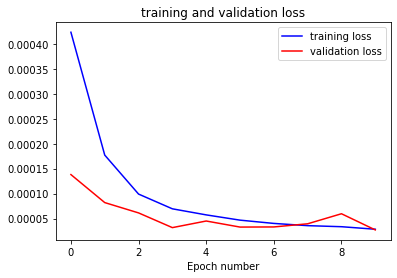

In [141]:
# Plot train and val_loss: Mean squared error
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.title('training and validation loss')
plt.legend()
plt.show()  

In [143]:
## Get model predictions:
#train_pred = model.predict(train_input)
val_pred = model.predict(val_input)
train_pred = model.predict(train_input)

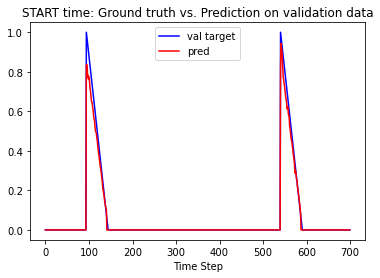

In [144]:
# Fidelity check: Plot predicted START time vs. target for on event in validation data
plt.plot(val_target[10000:10700,0], color = 'blue', label = 'val target')
plt.plot(val_pred[10000:10700,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

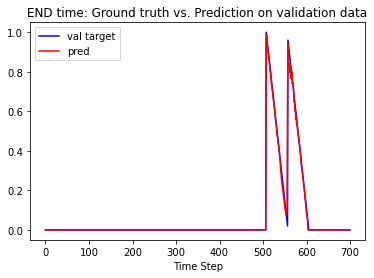

In [145]:
# Fidelity check: Plot predicted END time vs. target for on event in validation data
plt.plot(val_target[10000:10700,1], color = 'blue', label = 'val target')
plt.plot(val_pred[10000:10700,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on validation data')
plt.legend()
plt.show()

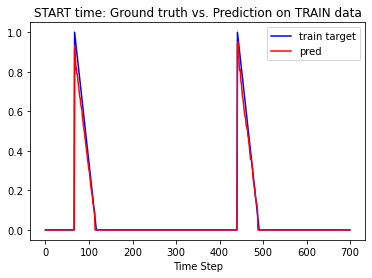

In [146]:
# Fidelity check: Plot predicted START time vs. target for on event in TRAIN data
plt.plot(train_target[9900:10600,0], color = 'blue', label = 'train target')
plt.plot(train_pred[9900:10600,0], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('START time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

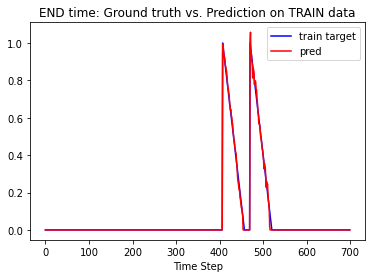

In [147]:
# Fidelity check: Plot predicted END time vs. target for on event in TRAIN data
plt.plot(train_target[9900:10600,1], color = 'blue', label = 'train target')
plt.plot(train_pred[9900:10600,1], color = 'red', label = 'pred')
plt.xlabel('Time Step')
plt.title('END time: Ground truth vs. Prediction on TRAIN data')
plt.legend()
plt.show()

In [148]:
## In our sliding window approach we have input_length overlapping samples for each time step.
## Only pick every input_length's target, to avoid overlap:
val_target_plain = val_target[np.arange(0,len(val_target),input_length)]
val_pred_plain = val_pred[np.arange(0,len(val_pred),input_length)]
train_target_plain = train_target[np.arange(0,len(train_target),input_length)]
train_pred_plain = train_pred[np.arange(0,len(train_pred),input_length)]

# Check dimensions and number of events:
print("val_target shape WITHOUT overlap: ", val_target_plain.shape)
print("val_pred shape WITHOUT overlap: ", val_pred_plain.shape)
print("val_target: number of ON switching events: ", np.sum((val_target_plain[:,0]!=0)))
print("val_target: number of OFF switching events: ", np.sum((val_target_plain[:,1]!=0)))
print("val_pred: number of ON switching events: ", np.sum((val_pred_plain[:,0]!=0)))
print("val_pred: number of OFF switching events: ", np.sum((val_pred_plain[:,1]!=0)))

print("\ntrain_target shape WITHOUT overlap: ", train_target_plain.shape)
print("train_pred shape WITHOUT overlap: ", train_pred_plain.shape)
print("train_target: number of ON switching events: ", np.sum((train_target_plain[:,0]!=0)))
print("train_target: number of OFF switching events: ", np.sum((train_target_plain[:,1]!=0)))
print("train_pred: number of ON switching events: ", np.sum((train_pred_plain[:,0]!=0)))
print("train_pred: number of OFF switching events: ", np.sum((train_pred_plain[:,1]!=0)))

val_target shape WITHOUT overlap:  (3110, 2)
val_pred shape WITHOUT overlap:  (3110, 2)
val_target: number of ON switching events:  7
val_target: number of OFF switching events:  7
val_pred: number of ON switching events:  8
val_pred: number of OFF switching events:  7

train_target shape WITHOUT overlap:  (21758, 2)
train_pred shape WITHOUT overlap:  (21758, 2)
train_target: number of ON switching events:  107
train_target: number of OFF switching events:  103
train_pred: number of ON switching events:  105
train_pred: number of OFF switching events:  101


In [149]:
### Restore appliance's power load from plain targets and predictions:

## First restore start and end times:

## Validation data:

# Initialize storage:
val_target_plain_start = np.zeros(len(val_target_plain) * input_length)
val_target_plain_end = np.zeros(len(val_target_plain) * input_length)
val_pred_plain_start = np.zeros(len(val_pred_plain) * input_length)
val_pred_plain_end = np.zeros(len(val_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(val_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_target_plain[i,0] * input_length)
    end_time_abs = int(val_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(val_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(val_pred_plain[i,0] * input_length)
    end_time_abs = int(val_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        val_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        val_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1

        
## Train data:

# Initialize storage:
train_target_plain_start = np.zeros(len(train_target_plain) * input_length)
train_target_plain_end = np.zeros(len(train_target_plain) * input_length)
train_pred_plain_start = np.zeros(len(train_pred_plain) * input_length)
train_pred_plain_end = np.zeros(len(train_pred_plain) * input_length)

# Loop over plain target:
for i in range(len(train_target_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_target_plain[i,0] * input_length)
    end_time_abs = int(train_target_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_target_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_target_plain_end[(i * input_length) + end_time_abs - 1] = 1
        
        
# Loop over plain pred:
for i in range(len(train_pred_plain)):
    
    # Check for non-zero start and end time, given as relative position in sample. 
    # Need to multiply with input_length, to restore absolute position.
    start_time_abs = int(train_pred_plain[i,0] * input_length)
    end_time_abs = int(train_pred_plain[i,1] * input_length)
    
    # Store start time for i-th sample, ONLY if start_time is non-zero:
    if start_time_abs != 0:
        train_pred_plain_start[(i * input_length) + start_time_abs - 1] = 1
    
    # Store end time for i-th sample, ONLY if start_time is non-zero:
    if end_time_abs != 0:
        train_pred_plain_end[(i * input_length) + end_time_abs - 1] = 1



In [150]:
### Then restore power load from restored start and end times:


## Val Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_target_plain_ON_OFF = val_target_plain_start - val_target_plain_end

# Initialize storage:
val_target_plain_load = np.zeros(len(val_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_target_plain_load[i] = np.max([0, val_target_plain_ON_OFF[i]])
    else:
        val_target_plain_load[i] = np.min([1, np.max([0, val_target_plain_load[i-1] + val_target_plain_ON_OFF[i]])])

# And finally multiply load series with target2_mean_load:
val_target_plain_load = val_target_plain_load * target2_mean_load


## Val Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
val_pred_plain_ON_OFF = val_pred_plain_start - val_pred_plain_end

# Initialize storage:
val_pred_plain_load = np.zeros(len(val_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(val_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        val_pred_plain_load[i] = np.max([0, val_pred_plain_ON_OFF[i]])
    else:
        val_pred_plain_load[i] = np.min([1, np.max([0, val_pred_plain_load[i-1] + val_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target2_mean_load:
val_pred_plain_load = val_pred_plain_load * target2_mean_load


## Train Target:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_target_plain_ON_OFF = train_target_plain_start - train_target_plain_end

# Initialize storage:
train_target_plain_load = np.zeros(len(train_target_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_target_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_target_plain_load[i] = np.max([0, train_target_plain_ON_OFF[i]])
    else:
        train_target_plain_load[i] = np.min([1, np.max([0, train_target_plain_load[i-1] + train_target_plain_ON_OFF[i]])])

# And finally multiply load series with target2_mean_load:
train_target_plain_load = train_target_plain_load * target2_mean_load


## Train Pred:

# Combine start and end times to one series containing switching events: ON = 1, OFF = -1
train_pred_plain_ON_OFF = train_pred_plain_start - train_pred_plain_end

# Initialize storage:
train_pred_plain_load = np.zeros(len(train_pred_plain) * input_length)

# Loop over switching events: If ON, set load to 1, if OFF, go back to zero.
for i in range(len(train_pred_plain_ON_OFF)):
    
    # First time step:
    if i == 0:
        train_pred_plain_load[i] = np.max([0, train_pred_plain_ON_OFF[i]])
    else:
        train_pred_plain_load[i] = np.min([1, np.max([0, train_pred_plain_load[i-1] + train_pred_plain_ON_OFF[i]])])

# And finally multiply load series with target2_mean_load:
train_pred_plain_load = train_pred_plain_load * target2_mean_load

Text(0, 0.5, 'Power [W]')

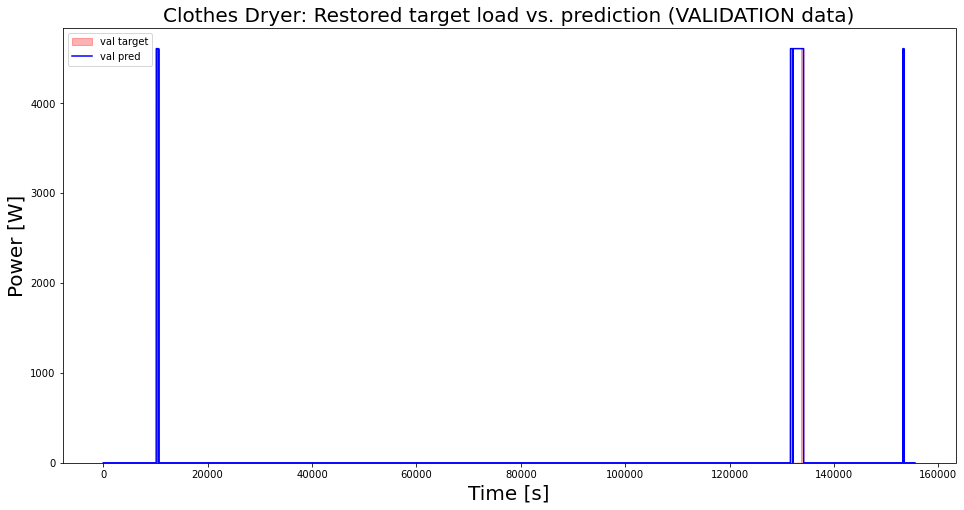

In [151]:
# Plot restored target load for Clothes Dryer vs. restored prediction on VALIDATION data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(val_target_plain_load[:])), val_target_plain_load[:], color="red", alpha=0.3, labels=['val target'])
ax.plot(val_pred_plain_load[:], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Clothes Dryer: Restored target load vs. prediction (VALIDATION data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

Text(0, 0.5, 'Power [W]')

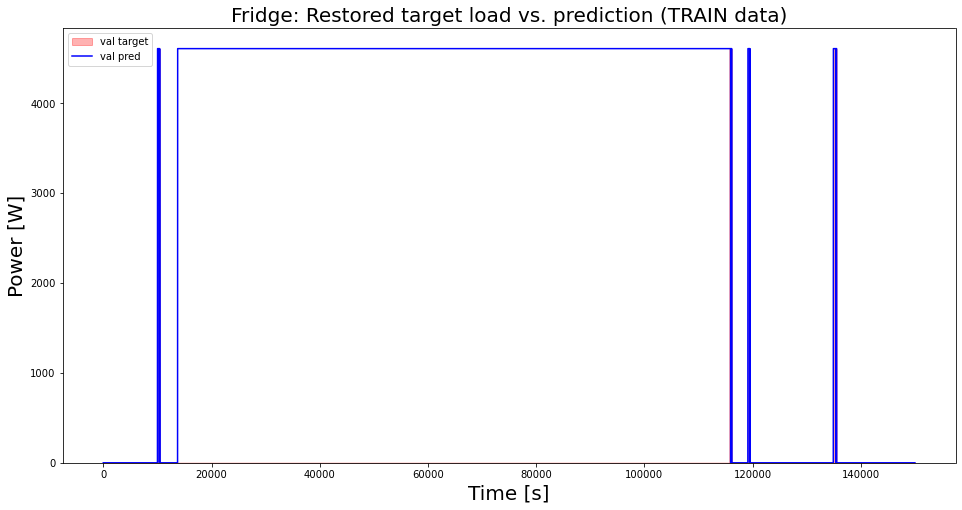

In [152]:
# Plot restored target load for Fridge vs. restored prediction on TRAIN data
# from 1st sample for house1:
fig, ax = plt.subplots(figsize=(16, 8))
ax.stackplot(range(len(train_target_plain_load[:150000])), train_target_plain_load[:150000], color="red", alpha=0.3, labels=['val target'])
ax.plot(train_pred_plain_load[:150000], color="blue", label='val pred')
plt.legend(loc='upper left')
plt.title('Fridge: Restored target load vs. prediction (TRAIN data)', fontsize=20)
plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Power [W]', fontsize=20)

### Model Evaluation

[Marwah and Han, 2011] describe **Precision, Recall and F-measure** as some metrics used for evaluation of our models' performance: Let $x$ be the predicted value and $x_0$ to be the ground truth. In our case we look at power consumption of a certain appliance at a certain time step. We then need to distinguish:

$$
x=0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow TN \\
x=0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow FN \\
x>0\,\,\,AND\,\,\,x_0=0\,\,\,\,\,\,\rightarrow FP \\
x>0\,\,\,AND\,\,\,x_0>0\,\,\,\,\,\,\rightarrow TP 
$$

Here TN, FN, FP and TP refer to "true negative", "false negative", "false positive" and "true positive", respectively. TP is then further split into "inaccurate true positive" (ITP) and "accurate true positive" (ATP), given $\frac{|x-x_0|}{x_0}>\rho$ or $\frac{|x-x_0|}{x_0}\leq\rho$, respectively, with some threshhold $\rho=0.2$.

We then define **Precision**=$\frac{ATP}{ATP + ITP + FP}$, **Recall**=$\frac{ATP}{ATP + ITP + FN}$ and **F-measure**=$\frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$.

In [153]:
# Define measures on VALIDATION data:
val_TN = sum((val_pred_plain_load == 0) & (val_target_plain_load == 0))
val_FN = sum((val_pred_plain_load == 0) & (val_target_plain_load > 0))
val_FP = sum((val_pred_plain_load > 0) & (val_target_plain_load == 0))
val_TP = sum((val_pred_plain_load > 0) & (val_target_plain_load > 0))
val_prec = val_TP / (val_TP + val_FP)
val_rec = val_TP / (val_TP + val_FN)
val_Fmeas = (2 * val_prec * val_rec) / (val_prec + val_rec)

# Define measures on TRAIN data:
train_TN = sum((train_pred_plain_load == 0) & (train_target_plain_load == 0))
train_FN = sum((train_pred_plain_load == 0) & (train_target_plain_load > 0))
train_FP = sum((train_pred_plain_load > 0) & (train_target_plain_load == 0))
train_TP = sum((train_pred_plain_load > 0) & (train_target_plain_load > 0))
train_prec = train_TP / (train_TP + train_FP)
train_rec = train_TP / (train_TP + train_FN)
train_Fmeas = (2 * train_prec * train_rec) / (train_prec + train_rec)

# Check measures:
print("train precision: ", np.round(train_prec * 100,1), "%")
print("train recall: ", np.round(train_rec * 100,1), "%")
print("train F-measure: ", np.round(train_Fmeas * 100,1), "%")
print("\nval precision: ", np.round(val_prec * 100,1), "%")
print("val recall: ", np.round(val_rec * 100,1), "%")
print("val F-measure: ", np.round(val_Fmeas * 100,1), "%")

train precision:  10.3 %
train recall:  93.7 %
train F-measure:  18.5 %

val precision:  48.8 %
val recall:  99.3 %
val F-measure:  65.4 %
